In [1]:
import os
import PIL
import glob
import time
import imageio
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as pt

from glob import glob
from IPython import display
from tensorflow.keras import layers, losses
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score

from typing import Iterable, List, Tuple, Any

In [2]:
tf.__version__

'2.5.0-dev20210130'

We will be attempting to style the facades dataset to match vangogh's style

In [3]:
train_dir: str = 'train/trainA'
test_dir: str = 'test/testA'
style_dir: str = 'data/vangogh2photo'
image_dir: str = 'data/facades'

## Utils
---

In [4]:
def list_files(directory: str, search: Iterable) -> List[str]:
    """
    list files
    """
    if isinstance(search, str):
        search = [search]

    output: List[str] = []
    for term in search:
        for filepath in glob(os.path.join(directory, term)):
            output.append(filepath)

    return output

In [5]:
def load_random_image(directory: str, search: Iterable) -> np.ndarray:
    filepaths = list_files(directory, search)
    rand_index = np.random.randint(0, high=len(filepaths))
    return np.asarray(PIL.Image.open(filepaths[rand_index]))

---

## Random Images From the Style and Image Datasets

In [6]:
random_image = load_random_image(os.path.join(style_dir, train_dir), "*.jpg")

In [7]:
random_image.shape

(256, 256, 3)

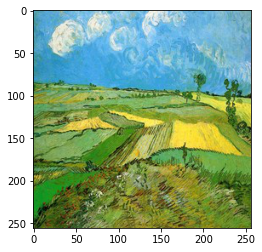

In [8]:
pt.imshow(random_image)

In [9]:
random_image = load_random_image(os.path.join(image_dir, train_dir), "*.jpg")

In [10]:
random_image.shape

(256, 256, 3)

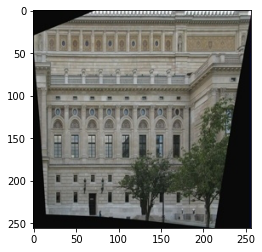

In [11]:
pt.imshow(random_image)

In [12]:
BUFFER_SIZE=64
BATCH_SIZE=16

In [13]:
dgen_params = dict(
    rescale           =  1./255,
    shear_range       =  0.0,
    zoom_range        =  0.0,
    horizontal_flip   =  True,
    brightness_range  =  (0.7, 1.2)
)

gen_params = dict(
    target_size       =  (256, 256),
    batch_size        =  BATCH_SIZE,
    color_mode        =  'rgb',
    class_mode        =  None
)

In [14]:
style_train_dgen = tf.keras.preprocessing.image.ImageDataGenerator(
    **dgen_params
)
image_train_dgen = tf.keras.preprocessing.image.ImageDataGenerator(
    **dgen_params
)

style_train_gen = style_train_dgen.flow_from_directory(
    os.path.join(style_dir, 'train'),
    **gen_params
)
image_train_gen = image_train_dgen.flow_from_directory(
    os.path.join(image_dir, 'train'),
    **gen_params
)

Found 400 images belonging to 1 classes.
Found 400 images belonging to 1 classes.


In [15]:
style_dataset = tf.data.Dataset.from_generator(lambda: style_train_gen, (tf.float32))

In [16]:
image_dataset = tf.data.Dataset.from_generator(lambda: image_train_gen, (tf.float32))

## Model Definitions
---

In the original GANILLA implementation they made use of a modified ResNet18,
so we will do something similar

This starts with an implementation of ResNet: https://medium.com/@divyanshuraj.6815/learn-to-code-in-tensorflow2-part2-b1c448abbf1e

In [17]:
class Autoencoder(tf.keras.models.Model):
    def __init__(self):
        super(Autoencoder, self).__init__()
        self.latent_dim = 128
        self.encoder = self._make_encoder_model()
        self.decoder = self._make_decoder_model()
        
    def call(self, x, training: bool = None) -> Tuple[Any]:
        encoded = self.encoder(x, training=training)
        decoded = self.decoder(encoded, training=training)
        
        return encoded, decoded
    
    def _make_encoder_model(self):
        model = tf.keras.models.Sequential()
        
        inp = layers.Input((256, 256, 3))
        model.add(tf.keras.applications.ResNet50V2(
            include_top=False,
            weights='imagenet',
            input_tensor=inp,
            input_shape=(256, 256, 3),
            pooling='avg'
        ))
        
        model.add(layers.Dense(self.latent_dim, use_bias=False, name='latent_output'))
        
        for layer in model.layers:
            if layer.name != 'latent_output':
                layer.trainable = False
                
        return model
    
    def _make_decoder_model(self):
        inp = layers.Input(shape=(4*4*8))

        x = layers.Reshape((4, 4, 8))(inp)
        
        x = layers.Conv2DTranspose(8, (5, 5), strides=(2, 2), padding='same', use_bias=False)(x)
        assert tuple(x.get_shape()) == (None, 8, 8, 8)
        x = layers.BatchNormalization()(x)
        x = layers.LeakyReLU()(x)
        
        x = layers.Conv2DTranspose(7, (5, 5), strides=(2, 2), padding='same', use_bias=False)(x)
        assert tuple(x.get_shape()) == (None, 16, 16, 7)
        x = layers.BatchNormalization()(x)
        x = layers.LeakyReLU()(x)

        x = layers.Conv2DTranspose(6, (5, 5), strides=(2, 2), padding='same', use_bias=False)(x)
        assert tuple(x.get_shape()) == (None, 32, 32, 6)
        x = layers.BatchNormalization()(x)
        x = layers.LeakyReLU()(x)

        x = layers.Conv2DTranspose(5, (5, 5), strides=(2, 2), padding='same', use_bias=False)(x)
        assert tuple(x.get_shape()) == (None, 64, 64, 5)
        x = layers.BatchNormalization()(x)
        x = layers.LeakyReLU()(x)

        x = layers.Conv2DTranspose(4, (5, 5), strides=(2, 2), padding='same', use_bias=False)(x)
        assert tuple(x.get_shape()) == (None, 128, 128, 4)
        x = layers.BatchNormalization()(x)
        x = layers.LeakyReLU()(x)
        
        x = layers.Conv2DTranspose(3, (5, 5), strides=(2, 2), padding='same', use_bias=False)(x)
        assert tuple(x.get_shape()) == (None, 256, 256, 3)
        x = layers.BatchNormalization()(x)
        x = layers.LeakyReLU()(x)

        return tf.keras.models.Model(inputs=inp, outputs=x)

In [18]:
autoencoder = Autoencoder()

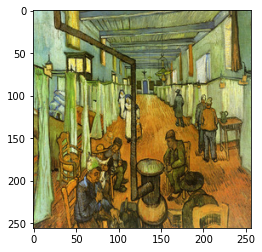

In [19]:
random_style_image = load_random_image(os.path.join(style_dir, train_dir), "*.jpg")
pt.imshow(random_style_image)

In [20]:
encoded_random_style_image, decoded_random_style_image = autoencoder(random_style_image.reshape((1, 256, 256, 3)), training=False)

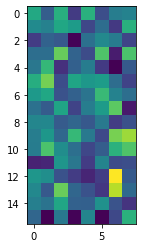

In [21]:
pt.imshow(encoded_random_style_image.numpy().reshape((16, -1)))

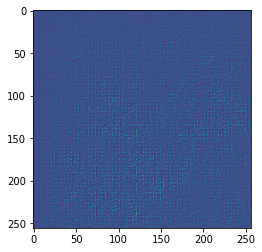

In [22]:
pt.imshow(decoded_random_style_image.numpy()[0, :, :, 0])

In [23]:
def make_discriminator_model():
    model = tf.keras.models.Sequential()
    
    inp = layers.Input((256, 256, 3))
    model.add(tf.keras.applications.ResNet152V2(
        include_top=False, 
        weights='imagenet',
        input_tensor=inp,
        input_shape=(256, 256, 3),
        pooling='max'
    ))
    
    model.add(layers.Dropout(0.3, name='disc_dropout'))
    model.add(layers.Flatten(name='disc_flatten'))
    model.add(layers.Dense(1, name='disc_output', use_bias=False))
    
    for layer in model.layers:
        if layer.name not in ['disc_dropout', 'disc_flatten', 'disc_output']:
            layer.trainable = False
            
    model.summary()
    return model

In [24]:
discriminator = make_discriminator_model()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet152v2 (Functional)     (None, 2048)              58331648  
_________________________________________________________________
disc_dropout (Dropout)       (None, 2048)              0         
_________________________________________________________________
disc_flatten (Flatten)       (None, 2048)              0         
_________________________________________________________________
disc_output (Dense)          (None, 1)                 2048      
Total params: 58,333,696
Trainable params: 2,048
Non-trainable params: 58,331,648
_________________________________________________________________


In [25]:
decision = discriminator(decoded_random_style_image)
print(decision)

tf.Tensor([[2.1843696]], shape=(1, 1), dtype=float32)


In [26]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [27]:
def autoencoder_loss(fake_output, original_image, autoencoded_image, alpha: float = 0.8, beta: float = 0.2):
    assert alpha + beta == 1.
    discriminator_loss = cross_entropy(tf.ones_like(fake_output), fake_output)
    encoding_loss = cross_entropy(original_image, autoencoded_image)
    
    return alpha * discriminator_loss + beta * encoding_loss

In [28]:
def discriminator_loss(real_output, fake_output, alpha: float = 0.5, beta: float = 0.5):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.ones_like(fake_output), fake_output)
    
    return alpha * real_loss + beta * fake_loss

In [29]:
autoencoder_optimizer = tf.keras.optimizers.RMSprop(lr=1e-5)
discriminator_optimizer = tf.keras.optimizers.RMSprop(lr=1e-5)

In [30]:
checkpoint_dir: str = 'style_transfer_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, 'ckpt')
checkpoint = tf.train.Checkpoint(autoencoder_optimizer=autoencoder_optimizer,
                                    discriminator_optimizer=discriminator_optimizer,
                                    autoencoder=autoencoder,
                                    discriminator=discriminator
                                )

In [31]:
EPOCHS = 50
image_dim = 256*256*3
num_examples_to_generate = 4*4

# these are the indices of the images we will feed into the partially trained network
# every epoch to visualize progress
random_images_index = np.random.randint(0, high=400, size=(num_examples_to_generate, EPOCHS))

In [32]:
@tf.function
def train_step(images_to_style, style_images):
    print('initiating train step')
    with tf.GradientTape() as auto_grad, tf.GradientTape() as disc_grad:
        _, autoencoded_image = autoencoder(images_to_style, training=True)
        
        real_output = discriminator(style_images, training=True)
        fake_output = discriminator(autoencoded_image, training=True)
        
        disc_loss = discriminator_loss(real_output, fake_output)
        autoenc_loss = autoencoder_loss(fake_output, images_to_style, autoencoded_image)
    print('calculating gradients')
    gradients_of_autoencoder = auto_grad.gradient(autoenc_loss, autoencoder.trainable_variables)
    gradients_of_discriminator = disc_grad.gradient(disc_loss, discriminator.trainable_variables)
    
    autoencoder_optimizer.apply_gradients(zip(gradients_of_autoencoder, autoencoder.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))      

In [33]:
def generate_and_save_images(autoencoder, epoch, test_input):
    # Notice `training` is set to False.
    # This is so all layers run in inference mode (batchnorm).
#     _, predictions = autoencoder(test_input, training=False)
    fig = pt.figure(figsize=(10, 10))

    for i in range(len(test_input)):
        _, prediction = autoencoder(test_input[i].reshape(1, 256, 256, 3), training=False)
#         print((prediction + 255) / 255)
        pt.subplot(1, 2, i+1)
        pt.imshow((prediction[0, :, :, :3] + 255) / 255)
        pt.axis('off')

    pt.savefig('autoencoder_image_at_epoch_{:04d}.png'.format(epoch))
    pt.show()

In [34]:
def train(images_to_style, style_images, display_test_images, epochs):
    for epoch in range(epochs):
        start = time.time()
        
        for images, styles in zip(images_to_style.take(100), style_images.take(100)):
#             print('starting training loop')
            train_step(images, styles)
        
        display.clear_output(wait=True)
        generate_and_save_images(autoencoder, 
                                    epoch+1,
                                    display_test_images)
        
        if (epoch + 1) % 15== 0:
            checkpoint.save(file_prefix=checkpoint_prefix)
            
        print(f'Time for epoch {epoch} is {time.time()-start}')
        
    display.clear_output(wait=True)
    generate_and_save_images(autoencoder,
                                epochs,
                                display_test_images)

In [35]:
autoencoder.summary()

Model: "autoencoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential (Sequential)      (None, 128)               23826944  
_________________________________________________________________
model (Functional)           (None, 256, 256, 3)       5732      
Total params: 23,832,676
Trainable params: 267,810
Non-trainable params: 23,564,866
_________________________________________________________________


In [36]:
discriminator.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet152v2 (Functional)     (None, 2048)              58331648  
_________________________________________________________________
disc_dropout (Dropout)       (None, 2048)              0         
_________________________________________________________________
disc_flatten (Flatten)       (None, 2048)              0         
_________________________________________________________________
disc_output (Dense)          (None, 1)                 2048      
Total params: 58,333,696
Trainable params: 2,048
Non-trainable params: 58,331,648
_________________________________________________________________


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


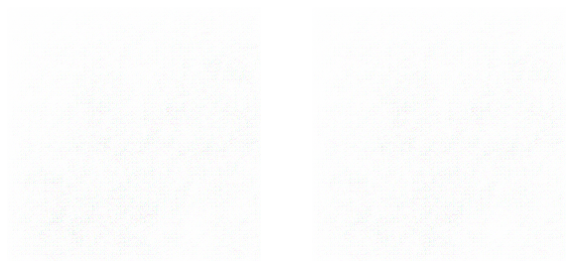

Time for epoch 1 is 49.617796182632446


In [ ]:
display_test_images = []
for i in range(2):
    display_test_images.append(load_random_image(os.path.join(image_dir, train_dir), "*.jpg"))
print("initiating training")
train(image_dataset, style_dataset, display_test_images, EPOCHS)